## Data Generation
Author: Allen Ross  
Date: 05/13/21   
In this notebook we will be generating some data from known kernels to test kernel learning methods.

In [1]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from gpflow.utilities import print_summary

Data generation scheme:  
 for i in 1:N   
 

In [2]:
## Specify data generating parameters
# Set seed for reproducibility
np.random.seed(9012)

# Number of individual units
num_units = 10

# Assign treatment group to each unit
treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

# Sample number of observations for each unit
num_obs = np.random.poisson(lam=12, size=num_units)

# Sample from uniform distribution for observation times
x = np.concatenate(
    [np.sort(np.round(np.random.uniform(low=0, high=12, size=i),1)) for i in num_obs],
    axis=0)

# Put unit ID and observation time together
df = np.array([np.repeat(np.arange(num_units), num_obs),
               np.repeat(treat_group, num_obs),
               x]).T
print('Size of observation set:', df.shape)
df[:5,]

Size of observation set: (126, 3)


array([[0. , 0. , 0. ],
       [0. , 0. , 1.4],
       [0. , 0. , 2. ],
       [0. , 0. , 2.4],
       [0. , 0. , 3.4]])

In [3]:
# Create range for simulated set as well
sim_x = np.arange(start=0, stop=12, step=0.1)
df_sim = np.hstack((np.repeat(np.arange(num_units), len(sim_x))[:, None],
               np.repeat(treat_group, len(sim_x))[:, None],
               np.tile(np.round(sim_x,2), reps=num_units)[:, None]))

# Get proper index of observed rows
obs_idx = (np.concatenate([np.where((df_sim == df[i,:]).sum(axis=1) == 3) 
                           for i in range(df.shape[0])]).flatten())

print('Size of simulation set:', df_sim.shape)
df_sim[:5,]

Size of simulation set: (1200, 3)


array([[0. , 0. , 0. ],
       [0. , 0. , 0.1],
       [0. , 0. , 0.2],
       [0. , 0. , 0.3],
       [0. , 0. , 0.4]])

### Kernels

* Kernel 1: individual offset + matern32 over time
* Kernel 2: individual offset + individual * squaredexp over time + periodic over time
* Kernel 3: individual offset + linear treatment effect
* Kernel 4: individual offset + polynomial treatment effect + individual * matern32 over time

In [4]:
## Specify kernels
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0, active_dims=[2]) + 
     gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]))

# Second kernel is random unit specfic effect + time varying unit specific effect + 
# periodic overall effect
k2 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
     gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0, active_dims=[2]) * 
     gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
     gpflow.kernels.Periodic(
         base_kernel=gpflow.kernels.SquaredExponential(
             variance=1.0, active_dims=[2]),
         period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
      gpflow.kernels.Coregion(output_dim=len(np.unique(treat_group)), rank=1, active_dims=[1]) * 
      gpflow.kernels.Linear(variance=0.1, active_dims=[2]))

# Fourth kernel is unit specific effect + changepoint (M32/M32)
k4 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
      gpflow.kernels.ChangePoints(kernels = [gpflow.kernels.Matern32(variance=5.0,lengthscales=0.5),
                                             gpflow.kernels.Matern32(variance=1.0,lengthscales=2.5)],
                                  locations = [3],
                                  steepness=1.0))
## Can't use changepoint model at the moment, as GPflow doesn't allow for multidimension CP kernels

# Fourth kernel is random unit effect + nonlinear random treatment effect over time + 
# nonlinear individual effect over time
k4 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
      gpflow.kernels.Coregion(output_dim=len(np.unique(treat_group)), rank=1, active_dims=[1]) * 
      gpflow.kernels.Polynomial(degree = 2, offset = 50, variance=0.1, active_dims=[2]) + 
      gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) *
      gpflow.kernels.Matern32(variance=1.0, lengthscales=3.0, active_dims=[2]))

# Kernel dictonary
kern_out = {'k1': {'model': k1},
            'k2': {'model': k2},
            'k3': {'model': k3},
            'k4': {'model': k4}}

Sampling from kernel k1
Sampling from kernel k2
Sampling from kernel k3
Sampling from kernel k4


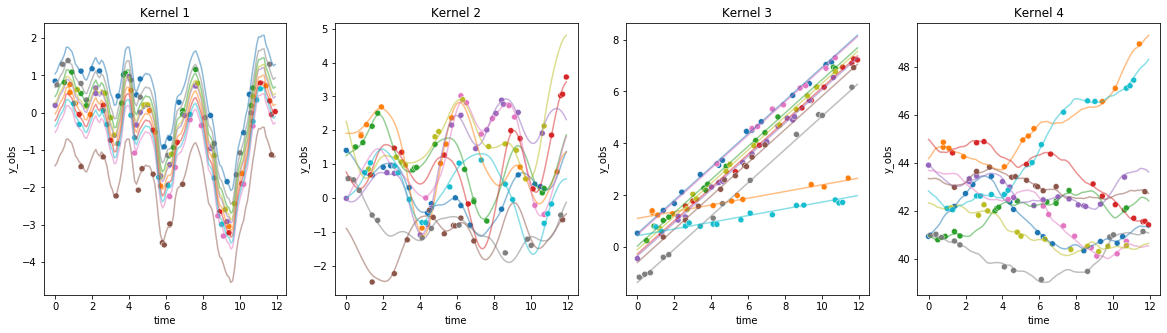

In [6]:
np.random.seed(9012)
# Specify plot object
f, axs = plt.subplots(1, len(kern_out), figsize=(20,5))
ic = 0
# Prepare data for plotting
df_plot = pd.DataFrame(df, 
                       columns=['unit','treatment','time'])
df_plot.unit = df_plot.unit.astype('category')
df_sim_plot = pd.DataFrame(df_sim, 
                       columns=['unit','treatment','time'])
df_sim_plot.unit = df_sim_plot.unit.astype('category')

# Sample from kernels
for k in kern_out.keys():
    print('Sampling from kernel {}'.format(k))
    kern_out[k]['f_true'] = np.random.multivariate_normal(
        np.zeros_like(df_sim[:,0]).flatten(),
        kern_out[k]['model'](df_sim),
        1
    )
    
    kern_out[k]['y_obs'] = (kern_out[k]['f_true'][0,obs_idx] + 
                            np.random.normal(scale=0.1, size=len(df)))
    
    # Plot resulting output
    df_sim_plot = df_sim_plot.assign(f_true = kern_out[k]['f_true'].flatten())
    df_plot = df_plot.assign(y_obs = kern_out[k]['y_obs'].flatten())
    p = sns.scatterplot(data=df_plot,
                    x='time',
                    y='y_obs',
                    hue='unit',
                    legend=False,
                       ax=axs[ic])
    p = sns.lineplot(data=df_sim_plot,
                    x='time',
                    y='f_true',
                    hue='unit',
                    legend=False,
                    alpha=0.5,
                    ax=axs[ic])
    p.set_title('Kernel {}'.format(ic+1))
    p.plot();
    
    ic += 1
    
# f_true = np.random.multivariate_normal(
#     np.zeros_like(df[:,0]).flatten(),
#     k1(df),
#     1
# )
# y_true = f_true + np.random.normal(scale=1)

# for i in range(num_units):
# #     plt.plot(x, y_true[i,:], 'x')
#     plt.plot(x, y_true[i,:], 'b')

# plt.plot(df[:,2], f_true.T, 'x')
# plt.plot(x, y_true.T);

In [13]:
# Drop plotting column
df_plot.drop(columns=['y_obs'], inplace=True)
for k in kern_out.keys():
    df_plot[k+'_obs'] = np.round(kern_out[k]['y_obs'], 2)
df_plot.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,0.0,0.85,1.41,0.54,40.94
1,0.0,0.0,1.4,1.12,0.68,1.42,42.18
2,0.0,0.0,2.0,1.18,0.91,1.68,42.72
3,0.0,0.0,2.4,1.12,0.95,2.12,43.10
4,0.0,0.0,3.4,0.45,0.31,2.80,43.44


In [14]:
# Save output data
df_plot.to_csv('simulated_data.csv', index=False)